# Speculative Decoding

---

## Pre-requisite

In [ ]:
%pip install azure-ai-ml
%pip install huggingface_hub
%pip install openai
%pip install matplotlib
%pip install pandas

In [ ]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential


try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [ ]:
from azure.ai.ml import MLClient


ml_client = MLClient.from_config(credential=credential)

## Create draft model

In [ ]:
registry_name = "test_centralus"
comp_name = "eagle3_chat_completion_pipeline"

In [ ]:
registry_ml_client = MLClient(credential=credential, registry_name=registry_name)
# eagle3_comp = registry_ml_client.components.get(name=comp_name, label="latest")
eagle3_comp = ml_client.components.get(name=comp_name, label="latest")
eagle3_comp

In [ ]:
draft_model_config = {
  "architectures": [
    "LlamaForCausalLMEagle3"
  ],
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 2048,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_key_value_heads": 8,
  "num_hidden_layers": 1,
  "pad_token_id": 0,
  "rms_norm_eps": 1e-05,
  "tie_word_embeddings": False,
  "torch_dtype": "float16",
  "transformers_version": "4.28.1",
  "use_cache": True,
  "vocab_size": 128256,
  "draft_vocab_size": 32000
}

In [ ]:
draft_config_path = "./data/config/draft_model_config.json"
input_data_path = "./data/train/sharegpt_train_small.jsonl"

In [ ]:
compute_name = "yesh-3-a100-uksouth"

In [ ]:
import json


with open(draft_config_path, "w") as f:
    json.dump(draft_model_config, f, indent=4)

In [ ]:
from azure.ai.ml.dsl import pipeline
from azure.ai.ml.entities._inputs_outputs import Input
from azure.ai.ml.constants._common import AssetTypes


@pipeline
def speculative_decoding_pipeline():
    node = eagle3_comp(
        mlflow_model_path=Input(type=AssetTypes.MLFLOW_MODEL, path="azureml://registries/azureml-meta/models/Meta-Llama-3-8B-Instruct/versions/9"),
        dataset_train_split=Input(type=AssetTypes.URI_FILE, path=input_data_path),
        dataset_validation_split=Input(type=AssetTypes.URI_FILE, path=input_data_path),
        draft_model_config=Input(type=AssetTypes.URI_FILE, path=draft_config_path),
        compute_model_import=compute_name,
        compute_eagle3_training=compute_name,
        num_epochs=1,
        # resume_from_checkpoint=None,
    )
    return {
        "output_model": node.outputs.output_model_path
    }

spec_dec_job = speculative_decoding_pipeline()

In [ ]:
spec_dec_job = ml_client.jobs.create_or_update(
    spec_dec_job, experiment_name="speculative-decoding-exp"
)
spec_dec_job

## Download models

In [ ]:
base_model_name = "nvidia/Llama-3.1-8B-Instruct-FP8"
# draft_model_name = "lmsys/sglang-EAGLE3-LLaMA3.1-Instruct-8B"

In [ ]:
from huggingface_hub import snapshot_download


base_model_dir = "./models/base"
draft_model_dir = "./models/draft"

snapshot_download(repo_id=base_model_name, local_dir=base_model_dir)
# snapshot_download(repo_id=draft_model_name, local_dir=draft_model_dir)

In [ ]:
ml_client.jobs.download(name=spec_dec_job.name, output_name="output_model", download_path=draft_model_dir, all=True)

## Change config

In [ ]:
import os
import shutil


# Move all files from subdirectories to the root directory
for root, dirs, files in os.walk(draft_model_dir):
    for file in files:
        if root != draft_model_dir:  # Skip files already in root
            source = os.path.join(root, file)
            destination = os.path.join(draft_model_dir, file)            
            shutil.move(source, destination)

# Remove empty subdirectories
for root, dirs, files in os.walk(draft_model_dir, topdown=False):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        if not os.listdir(dir_path):  # Only remove if empty
            os.rmdir(dir_path)

In [ ]:
import json


draft_config = json.load(open(f"{draft_model_dir}/config.json"))

draft_config = {
    **draft_config,
    "max_position_embeddings": 131072,
    "rope_scaling": {
        "factor": 8,
        "high_freq_factor": 4,
        "low_freq_factor": 1,
        "original_max_position_embeddings": 8192,
        "rope_type": "llama3"
    }
}

with open(f"{draft_model_dir}/config.json", "w") as f:
    json.dump(draft_config, f, indent=4)

## Upload model as a whole

In [ ]:
from azure.ai.ml.entities import Model


model = Model(
    path="./models", # Path to your model files
    name="llama-3-1-speculative",
)
ml_client.models.create_or_update(model)

## Create environment

In [ ]:
from azure.ai.ml.entities import Environment, BuildContext


env = Environment(
    build=BuildContext(path="./environment"),
    name="speculative-env",
    description="Environment for speculative decoding inference using sglang.",
    inference_config={
        "liveness_route": {
            "port": 30000,
            "path": "/health"
        },
        "readiness_route": {
            "port": 30000,
            "path": "/health_generate"
        },
        "scoring_route": {
            "port": 30000,
            "path": "/"
        }
    }
)

ml_client.environments.create_or_update(env)

## Create an online endpoint

In [ ]:
endpoint_name = "llama-3-1-speculative-endpoint"

In [ ]:
from azure.ai.ml.entities import ManagedOnlineEndpoint


endpoint = ManagedOnlineEndpoint(
   name=endpoint_name,
   auth_mode="key" # Use "aml_token" for token-based authentication
)

ml_client.online_endpoints.begin_create_or_update(endpoint).wait()

In [ ]:
deployment_name = "llama-3-1-spec-dep"

In [ ]:
from azure.ai.ml.entities import ManagedOnlineDeployment, ProbeSettings
from azure.ai.ml.entities._deployment.deployment_settings import OnlineRequestSettings


liveness_probe = ProbeSettings(
    initial_delay=2000,
    period=10,
    timeout=2,
    success_threshold=1,
    failure_threshold=30,
)

readiness_probe = ProbeSettings(
    initial_delay=2000,
    period=10,
    timeout=2,
    success_threshold=1,
    failure_threshold=30,
)

env_vars = {
    "BASE_MODEL": "/var/model-mount/models/base",
    "DRAFT_MODEL": "/var/model-mount/models/draft",
    "SGLANG_ARGS": "--tp-size 1 --max-running-requests 32 --mem-fraction-static 0.8 --speculative-algorithm EAGLE3 --speculative-num-steps 3 --speculative-eagle-topk 2 --speculative-num-draft-tokens 4 --dtype float16 --attention-backend fa3 --host 0.0.0.0 --port 30000 --enable-torch-compile",
    "SGLANG_ALLOW_OVERWRITE_LONGER_CONTEXT_LEN": "1",
    "SGL_HOST": "0.0.0.0",
    "SGL_PORT": "30000",
}

deployment = ManagedOnlineDeployment(
    name=deployment_name,
    endpoint_name=endpoint_name,
    model=model,
    model_mount_path="/var/model-mount",
    environment=env,
    environment_variables=env_vars,
    instance_type="Standard_NC40ads_H100_v5",
    # instance_type="STANDARD_ND96ISRF_H100_V5",
    # instance_type="Standard_ND96amsr_A100_v4",
    instance_count=1,
    liveness_probe=liveness_probe,
    readiness_probe=readiness_probe,
    request_settings=OnlineRequestSettings(
        request_timeout_ms=60000,
        max_concurrent_requests_per_instance=32,
    )
)

ml_client.online_deployments.begin_create_or_update(deployment).wait()

........................

## Invoke endpoint

In [ ]:
from openai import OpenAI


api_key = ml_client.online_endpoints.get_keys(name=endpoint_name).primary_key
base_url = ml_client.online_endpoints.get(name=endpoint_name).scoring_uri.replace("/score", "/v1")  # replace with /v1/chat/completions when using requests library

client = OpenAI(
    base_url=base_url,
    api_key=api_key
)

response = client.chat.completions.create(
    model="",  # This is a no-op, the actual model is defined in your deployment
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Come up with a joke on AI"}
    ],
    temperature=0.7,
    max_tokens=1024
)

print(response.choices[0].message.content)

## Performance

In [165]:
# python3 bench_serving.py --model /models/base --backend sglang --dataset-path /sgl-workspace/sglang/ShareGPT_V3_unfiltered_cleaned_split.json --dataset-name sharegpt --request-rate 20 --num-prompts 50 --port 30000 --disable-shuffle

# sglang as backend, with draft model
spec_dec_res = {
    "Backend": "sglang",
    "Traffic request rate": 20.0,
    "Max request concurrency": "not set",
    "Successful requests": 50,
    "Benchmark duration (s)": 5.81,
    "Total input tokens": 20949,
    "Total generated tokens": 12663,
    "Total generated tokens (retokenized)": 12636,
    "Request throughput (req/s)": 8.60,
    "Input token throughput (tok/s)": 3604.40,
    "Output token throughput (tok/s)": 2178.75,
    "Total token throughput (tok/s)": 5783.15,
    "Concurrency": 19.55,
    "End-to-End Latency": {
      "Mean E2E Latency (ms)": 2272.59,
      "Median E2E Latency (ms)": 2142.33
    },
    "Time to First Token": {
      "Mean TTFT (ms)": 94.14,
      "Median TTFT (ms)": 33.70,
      "P90 TTFT (ms)": 242.53,
      "P99 TTFT (ms)": 441.44
    },
    "Time per Output Token (excl. 1st token)": {
      "Mean TPOT (ms)": 9.57,
      "Median TPOT (ms)": 9.70,
      "P90 TPOT (ms)": 12.19,
      "P99 TPOT (ms)": 15.40
    },
    "Inter-token Latency": {
      "Mean ITL (ms)": 22.73,
      "Median ITL (ms)": 22.22,
      "P90 ITL (ms)": 38.77,
      "P99 ITL (ms)": 83.72
    }
}

In [161]:
# vllm as backend, without draft model
non_spec_dec_res = {
    "Backend": "vllm",
    "Traffic request rate": 20.0,
    "Max request concurrency": "not set",
    "Successful requests": 50,
    "Benchmark duration (s)": 8.21,
    "Total input tokens": 20949,
    "Total generated tokens": 12663,
    "Total generated tokens (retokenized)": 12642,
    "Request throughput (req/s)": 6.09,
    "Input token throughput (tok/s)": 2551.54,
    "Output token throughput (tok/s)": 1542.32,
    "Total token throughput (tok/s)": 4093.86,
    "Concurrency": 22.46,
    "End-to-End Latency": {
      "Mean E2E Latency (ms)": 3688.27,
      "Median E2E Latency (ms)": 3790.89
    },
    "Time to First Token": {
      "Mean TTFT (ms)": 305.72,
      "Median TTFT (ms)": 41.66,
      "P90 TTFT (ms)": 1101.27,
      "P99 TTFT (ms)": 1416.18
    },
    "Time per Output Token (excl. 1st token)": {
      "Mean TPOT (ms)": 14.67,
      "Median TPOT (ms)": 15.30,
      "P90 TPOT (ms)": 17.28,
      "P99 TPOT (ms)": 20.38
    },
    "Inter-token Latency": {
      "Mean ITL (ms)": 13.43,
      "Median ITL (ms)": 14.62,
      "P90 ITL (ms)": 15.53,
      "P99 ITL (ms)": 45.39
    }
}


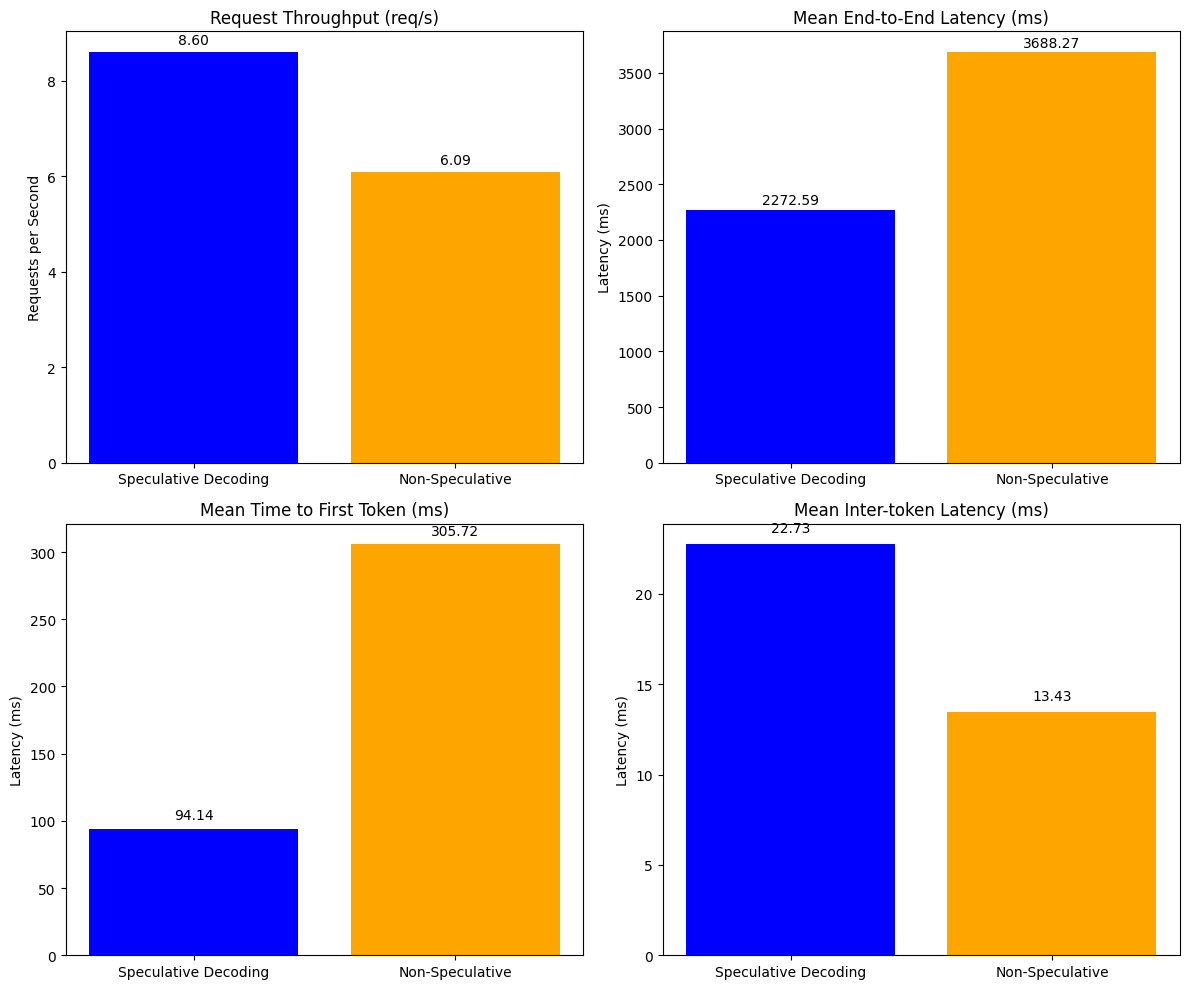

In [169]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 2, figsize=(12, 10))

def plot_metric(ax, title, ylabel, values, labels, colors, text_offset=0.1):
    bars = ax.bar(labels, values, color=colors)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + text_offset, f'{height:.2f}', ha='center', va='bottom')
    return bars

# Request Throughput
plot_metric(
    axs[0, 0],
    'Request Throughput (req/s)',
    'Requests per Second',
    [spec_dec_res['Request throughput (req/s)'], non_spec_dec_res['Request throughput (req/s)']],
    ['Speculative Decoding', 'Non-Speculative'],
    ['blue', 'orange'],
    text_offset=0.1
)

# Mean End-to-End Latency
plot_metric(
    axs[0, 1],
    'Mean End-to-End Latency (ms)',
    'Latency (ms)',
    [spec_dec_res['End-to-End Latency']['Mean E2E Latency (ms)'], non_spec_dec_res['End-to-End Latency']['Mean E2E Latency (ms)']],
    ['Speculative Decoding', 'Non-Speculative'],
    ['blue', 'orange'],
    text_offset=20
)

# Mean Time to First Token
plot_metric(
    axs[1, 0],
    'Mean Time to First Token (ms)',
    'Latency (ms)',
    [spec_dec_res['Time to First Token']['Mean TTFT (ms)'], non_spec_dec_res['Time to First Token']['Mean TTFT (ms)']],
    ['Speculative Decoding', 'Non-Speculative'],
    ['blue', 'orange'],
    text_offset=5
)

# Mean Inter-token Latency
plot_metric(
    axs[1, 1],
    'Mean Inter-token Latency (ms)',
    'Latency (ms)',
    [spec_dec_res['Inter-token Latency']['Mean ITL (ms)'], non_spec_dec_res['Inter-token Latency']['Mean ITL (ms)']],
    ['Speculative Decoding', 'Non-Speculative'],
    ['blue', 'orange'],
    text_offset=0.5
)

plt.tight_layout()
plt.show()